# Noise Curtailment design

### Setup the connection to WFA SDK

**Requires** the windfarmer python package to be installed in your local python environment.

Further instructions on how to setup in the [WindFarmer Automation Repo](https://github.com/dnv-opensource/WindFarmer-automation/blob/main/README.md)

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import windfarmer.sdk
import os
import itertools
import pandas as pd
from helper_functions import *

In [2]:
windfarmer_installation_folder = r'C:\Program Files\DNV\WindFarmer - Analyst 1.5.3'
wf = windfarmer.sdk.Sdk(windfarmer_installation_folder)
print(' > SDK is now up and running!')

 > SDK is now up and running!


### Open the workbook

In [3]:
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
workbook_path = os.path.join(root_dir, 'DemoData', 'OnshorePoland', 'OnShorePLDemo_Noise.wwx')

wf.Toolbox.OpenWorkbook(workbook_path)


### Set the noise limit at all the receptors

In [4]:
nighttime_noise_limit = 35.0
set_noise_limit_all_receptors(wf.Workbook, nighttime_noise_limit)

Setting all receptors noise limit to 35.0 dB


### What is the best mode selection for each turbine

<img src="noise cube.png" width="75%" height="75%" />

In [5]:
# Modes
turbine_type_name = "Bladed Concept Model 6.2-MW 162-D Onshore"
modes = ["Normal", "NM2", "NM3", "NM4"]
n_modes = len(modes)			
modes_as_dict = get_list_as_dict(modes)

# Receptors
receptors = ["Receptor 21", "Receptor 49", "Receptor 11"]
n_receptors = len(receptors)
receptors_as_dict = get_list_as_dict(receptors)

# Turbines
turbines = get_list_turbines(wf.Workbook)
n_turbines = len(turbines)
turbines_as_dict = get_list_as_dict(turbines)

### Calculate noise for each mode

* Loop noise modes, calculating contribution of each turbine at each receptor
* Obtain the gross energy for each turbine in each mode


In [6]:
# Store noise per mode per turbine for receptors (NX = n_modes, NY = n_turbines, NZ = n_receptors
noise_per_mode_from_turbine_for_receptors = [0] * n_modes * n_turbines* n_receptors
# Store gross energy per mode per turbines
gross_per_mode_per_turbine = [0] * n_modes * n_turbines

for mode_id in modes:
    print("Calculating mode: {}".format(mode_id))
    # Set the mode
    set_mode_on_turbine_type(wf.Workbook, mode_id, turbine_type_name)
    mode_idx = modes_as_dict[mode_id]

    # Run noise calculation
    wf.Toolbox.CalculateNoise()

    # Parse noise results
    parse_noise_results_and_store(wf.Workbook, receptors, receptors_as_dict, turbines_as_dict, mode_idx, n_modes, n_turbines, noise_per_mode_from_turbine_for_receptors)

    print("... calculating energy")
    # Run Energy calculations
    scenario = run_energy_calculation(wf.Workbook, wf.Toolbox)
    
    # Parse energy results
    parse_energy_results_and_store(scenario, turbines, turbines_as_dict, mode_idx, n_modes, gross_per_mode_per_turbine)
    

Calculating mode: Normal
... calculating energy
Calculating mode: NM2
... calculating energy
Calculating mode: NM3
... calculating energy
Calculating mode: NM4
... calculating energy


### Verify mode combinations

* Which mode combinations do not exceed the limit
* Calculate an overall gross for those mode combinations


In [7]:
# Generate all the possible combinations
all_mode_combinations = list(itertools.product(modes, repeat=n_turbines))
columns = ["Gross AEP [MWh/yr]",] + turbines
combinations_output = pd.DataFrame(columns=columns)

for combination in all_mode_combinations:			
    is_noise_exceeded = check_strategy_for_all_receptors(combination, receptors, receptors_as_dict, n_turbines, modes_as_dict, n_modes, noise_per_mode_from_turbine_for_receptors, nighttime_noise_limit)
    
    if not is_noise_exceeded:
        gross = get_gross_for_strategy(combination, n_turbines, modes_as_dict, n_modes, gross_per_mode_per_turbine)
        result = pd.DataFrame([(gross,) + combination], columns=columns)
        combinations_output = pd.concat([combinations_output, result])

### Sort and plot

,Gross AEP [MWh/yr],Turbine 4,Turbine 5,Turbine 6,Turbine 7,Turbine 8,Turbine 9,Turbine 10,Turbine 12
0,128.207965,NM3,NM4,NM3,NM4,NM4,NM3,NM2,Normal


646 combinations of 65536 did not exceed the noise limit.


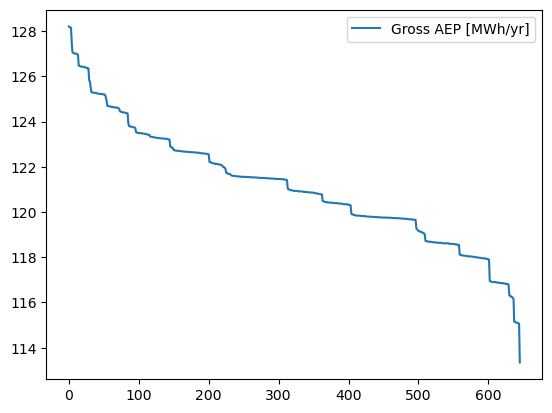

In [8]:
sorted_combinations = combinations_output.sort_values(by='Gross AEP [MWh/yr]', ascending=False)
sorted_combinations.index = pd.RangeIndex(start=0, stop=sorted_combinations.shape[0], step=1)
display(sorted_combinations.head(1))
sorted_combinations.plot(y='Gross AEP [MWh/yr]')
print(f"{combinations_output.shape[0]} combinations of {len(all_mode_combinations)} did not exceed the noise limit.")

### Paste curtailment strategy to workbook

In [9]:
print(sorted_combinations.iloc[0, sorted_combinations.columns != 'Gross AEP [MWh/yr]'].to_json(indent=2))

{
  "Turbine 4":"NM3",
  "Turbine 5":"NM4",
  "Turbine 6":"NM3",
  "Turbine 7":"NM4",
  "Turbine 8":"NM4",
  "Turbine 9":"NM3",
  "Turbine 10":"NM2",
  "Turbine 12":"Normal"
}


### Finalise

Revert the mode on the turbine type to be the normal mode

Release the workbook

In [10]:
set_mode_on_turbine_type(wf.Workbook, "Normal", turbine_type_name)

In [11]:
wf.Toolbox.NewWorkbook()